In [1]:
%matplotlib inline

In [2]:
import pandas as pd

import matplotlib
matplotlib.rcParams['figure.dpi'] = 200

import logging

from ihrem.timeslice import ms
from ihrem import paths
from ihrem.analysis import stim
from ihrem.analysis import cycles

from ihrem.figs_cpg import fig1

import warnings

warnings.simplefilter(action='error', category=FutureWarning)
pd.set_option('mode.chained_assignment','raise')
logging.basicConfig(level=logging.WARNING)

reg_full = paths.Registry.read_excel()

# Fig 1c

In [3]:
exp = reg_full.get_entry('GL1380_20230728_sleep')

In [4]:
first_timestamp = exp.get_loader().get_first_timestamp()
exp_beta_detailed = exp.load_all_beta_traces(area='CLA').normalize_by_quantiles()
light_wins = stim.load_light_wins(reg_full, exp.name)

  0%|          | 0/1 [00:00<?, ?it/s]

Saving: /gpfs/laur/data/fenkl/from_luis/fig1/24h/beta_GL1380_20230728_sleep_racorr.pdf


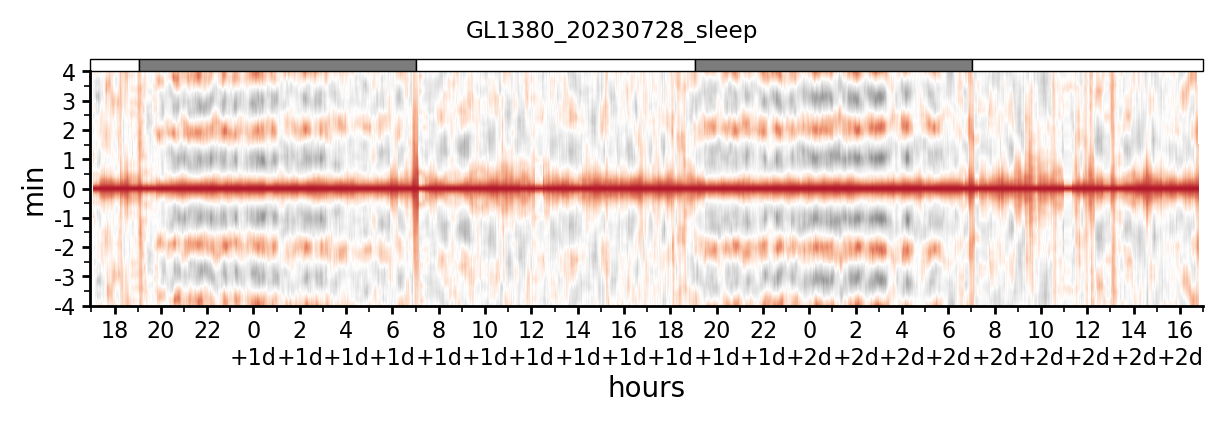

In [5]:
beta_racorr, f = fig1.plot_24h_beta_racorr(exp_beta_detailed, first_timestamp, light_wins=light_wins)
fig1.savefig(f, f'24h/beta_{exp.name}_racorr')

# Fig 1 g & h (example beta)

In [6]:
reg_sel = reg_full.sel_mask(
    reg_full['stim'].isin(['light pulses'])
    & reg_full['state'].isin(['sleep'])
    & (reg_full['lesion'] != 'BST')
    & reg_full['cap'].isna()
    & reg_full.is_bilat('CLA')
)


reg_sel

In [7]:
exp_beta_detailed = reg_sel.load_all_beta_traces_multi(area='CLA').normalize_by_quantiles()

exp_beta_comb = exp_beta_detailed.groupby_max('exp_name')

load beta:   0%|          | 0/71 [00:00<?, ?it/s]

In [8]:
analysis_windows = stim.collect_analysis_windows(reg_sel, pulse_len=(0, ms(seconds=100)))

beta_cut = exp_beta_detailed.cut_merge(analysis_windows).normalize_by_quantiles()
beta_cut = beta_cut.groupby_max(['exp_name', 'win_idx']).normalize_by_quantiles()

  0%|          | 0/71 [00:00<?, ?it/s]

Found 479 pulses in total


Saving: /gpfs/laur/data/fenkl/from_luis/fig1/beta_1s.pdf


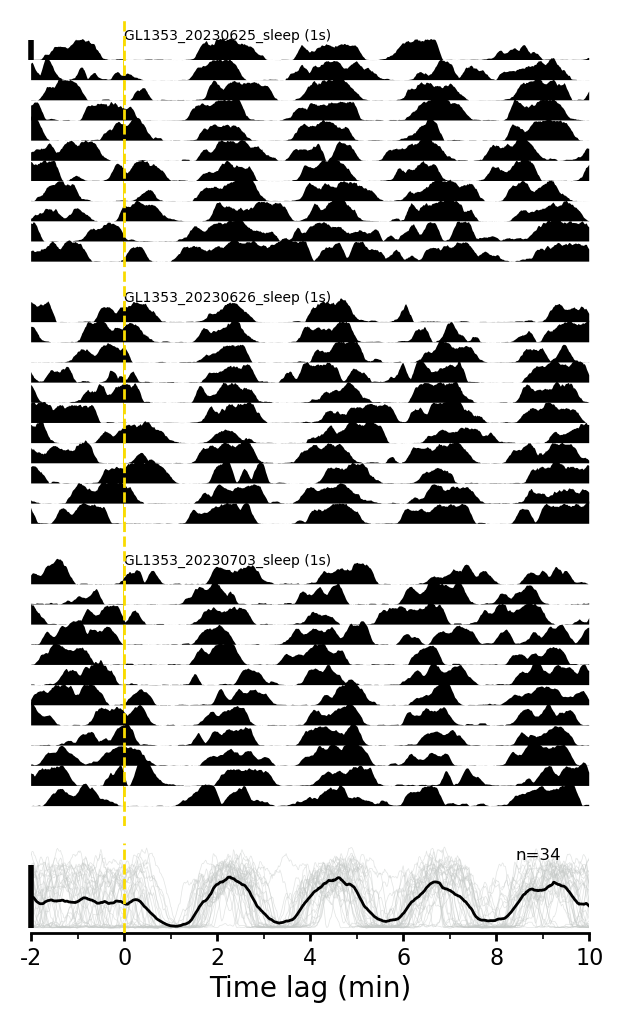

In [9]:
f = fig1.plot_examples_multiple_nights(
    beta_cut.crop((ms(minutes=-2), ms(minutes=10))).downsample(ms(seconds=1)),
    exp_names=[
        'GL1353_20230625_sleep',
        'GL1353_20230626_sleep',
        'GL1353_20230703_sleep',
    ],
    summary_func=pd.DataFrame.mean,
)

fig1.savefig(f, f'beta_1s')

Saving: /gpfs/laur/data/fenkl/from_luis/fig1/beta_multiple_durations.pdf


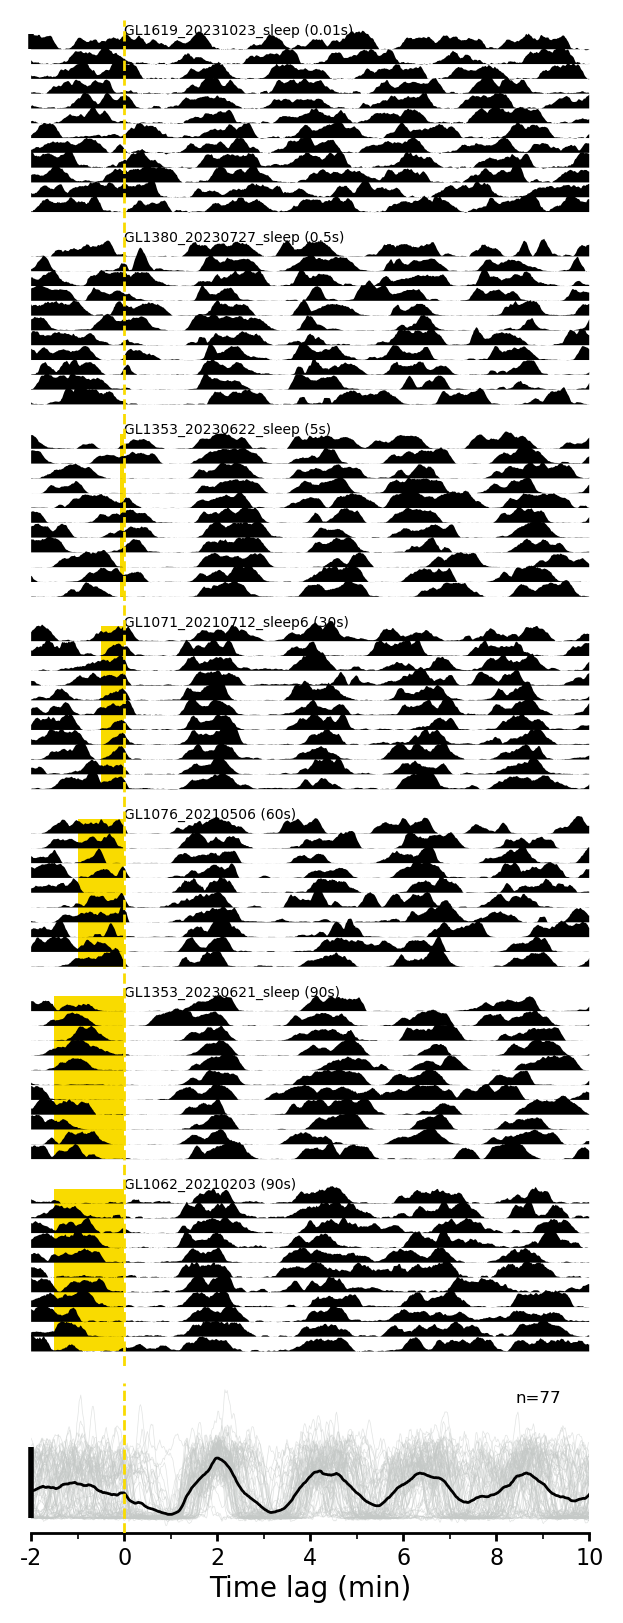

In [10]:
f = fig1.plot_examples_multiple_nights(
    beta_cut.crop((ms(minutes=-2), ms(minutes=10))).downsample(ms(seconds=1)),
    exp_names=[
        'GL1619_20231023_sleep',  # (0.01s)
        'GL1380_20230727_sleep',  # (0.5s)
        'GL1353_20230622_sleep',  # (5s)
        'GL1071_20210712_sleep6',  # (30s)
        'GL1076_20210506',  # (60s)
        'GL1353_20230621_sleep',  # 90s
        'GL1062_20210203',  # (90s)
    ],
    figsize=(3, 8),
    summary_func=pd.DataFrame.mean,
)

fig1.savefig(f, f'beta_multiple_durations')

In [11]:
exp_rem_wins = cycles.extract_rem_wins_multi(exp_beta_comb)

analysis_windows['first_rem_time'] = fig1.detect_first_rem_post_pulse(exp_rem_wins, analysis_windows)
analysis_windows['first_rem_time_s'] = analysis_windows['first_rem_time'] / ms(seconds=1)

rem wins:   0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/479 [00:00<?, ?it/s]

In [12]:
fig1.print_reset_stats(
    analysis_windows.sel_isin(exp_name=[
        'GL1353_20230625_sleep',
        'GL1353_20230626_sleep',
        'GL1353_20230703_sleep',
    ]))

 mean±std:  99± 15 	median: 97s; [25th, 75th] percentiles: [91, 106]s; n=34


In [13]:
fig1.print_reset_stats(
    analysis_windows.sel_isin(exp_name=[
        'GL1619_20231023_sleep',  # (0.01s)
        'GL1380_20230727_sleep',  # (0.5s)
        'GL1353_20230622_sleep',  # (5s)
        'GL1071_20210712_sleep6',  # (30s)
        'GL1076_20210506',  # (60s)
        'GL1353_20230621_sleep',  # 90s
        'GL1062_20210203',  # (90s)
    ]))

 mean±std:  84± 16 	median: 82s; [25th, 75th] percentiles: [77, 93]s; n=77


In [14]:
fig1.print_reset_stats(
    analysis_windows.sel(pulse_len=ms(seconds=90)),
)

 mean±std:  75± 24 	median: 77s; [25th, 75th] percentiles: [66, 83]s; n=66


# REM reaches to the end of 90s pulses?

In [15]:
reg_sel = reg_full.sel_mask(
    reg_full['stim'].isin(['light pulses'])
    & reg_full['state'].isin(['sleep'])
    & (reg_full['lesion'] != 'BST')
    & reg_full['cap'].isna()
    & reg_full.is_bilat('CLA')
)


analysis_windows = stim.collect_analysis_windows(reg_sel, pulse_len=ms(seconds=90))

reg_sel = reg_sel.sel_mask(analysis_windows['exp_name'].unique())

  0%|          | 0/71 [00:00<?, ?it/s]

Found 66 pulses in total


In [16]:
exp_beta_detailed = reg_sel.load_all_beta_traces_multi(area='CLA').normalize_by_quantiles()
exp_beta_comb = exp_beta_detailed.groupby_max('exp_name').normalize_by_quantiles()
exp_rem_wins = cycles.extract_rem_wins_multi(exp_beta_comb)

load beta:   0%|          | 0/6 [00:00<?, ?it/s]

rem wins:   0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
rem_traces = cycles.extract_rem_traces(analysis_windows, exp_rem_wins)

  0%|          | 0/66 [00:00<?, ?it/s]

In [18]:
fig1.plot_rem_prob(rem_traces.crop((ms(minutes=-4), ms(minutes=12))))